In [25]:
from pathlib import Path
import re
import numpy as np
from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    normal_cutoff = [cutoff[0], cutoff[1]]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False, fs=fs)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tsdir = '/home/anton/Documents/Tulane/Research/UKBB/Cypress/ts'

tr = 0.735
ps = dict()

a,b = np.triu_indices(264,1)

for ts in Path(tsdir).iterdir():
    m = re.match('(\d+)_(\d+)_(\d)_0_ts.csv', ts.name)
    if not m:
        continue
    subid = int(m.group(1))
    field = int(m.group(2))
    scannum = int(m.group(3))
    if subid != 1005815:
        continue
    if field != 20249:
        continue
    if scannum != 2:
        continue
    try:
        data = np.genfromtxt(str(ts), delimiter=',')
        ts1 = butter_bandpass_filter(data, [0.01, 0.15], 1/tr)
        p = np.corrcoef(ts1)
        if np.sum(np.isnan(p)) > 0:
            print(f'Bad sub {subid}')
            continue
        ps[subid] = p[a,b]
        if len(ps) % 100 == 0:
            print(f'Done {len(ps)}')
    except:
        print(f'Bad sub {subid}')
        continue
#     if len(rest1) < 15000:
#         break
    
print('Complete')

Complete


In [3]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [3]:
avg = np.zeros(34716)

for p in ps.values():
    avg += p/len(ps)

print('Done')

Done


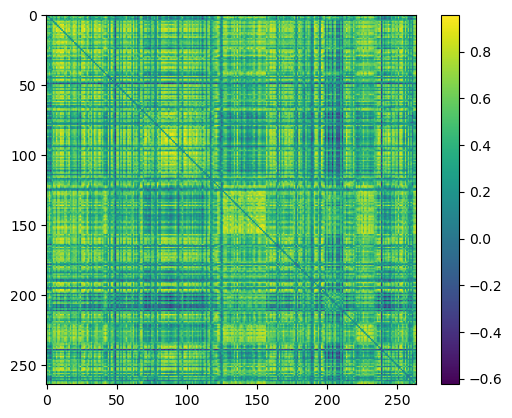

In [26]:
import matplotlib.pyplot as plt
import random

plt.imshow(remap(vec2mat(ps[random.choice(list(ps.keys()))])))
# plt.imshow(remap(vec2mat(avg)))
plt.colorbar()
plt.show()

In [12]:
import pickle

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/UKB/'

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

fc = []
age = []

for sub in demo['f_21003_2_0']:
    if sub in ps:
        a = demo['f_21003_2_0'][sub]
        p = ps[sub]
        fc.append(p)
        age.append(a)

age = np.array(age)
fc = np.stack(fc)

print(len(age), fc.shape)

17011 (17011, 34716)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

def rmse(yhat, y):
    return np.mean((yhat-y)**2)**0.5

for _ in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, age, train_size=0.8)
    
    reg = Ridge(alpha=1000).fit(xtr, ytr)
    null = rmse(np.mean(ytr), yt)
    yhat = reg.predict(xt)
    acc = rmse(yhat, yt)
    print(null, acc)

7.584396456430904 5.626634293760772


KeyboardInterrupt: 